In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
import ast
from pyvis.network import Network
import plotly.graph_objects as go

In [37]:
class KMeansPyTorch:
    def __init__(self, num_clusters, num_iterations=100, batch_size=1000, device='cuda'):
        self.num_clusters = num_clusters
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.cluster_centers = None
        self.device = device

    def fit(self, data):
        num_samples, num_features = data.shape

        # Convert the data to a PyTorch tensor and move it to the specified device
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)

        # Initialize cluster centers randomly and move them to the specified device
        initial_indices = np.random.choice(num_samples, self.num_clusters, replace=False)
        self.cluster_centers = data_tensor[initial_indices].clone()

        # Function to compute the distance between points and cluster centers
        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance

        for iteration in range(self.num_iterations):
            print(f"Iteration {iteration + 1}/{self.num_iterations}")

            # Assign clusters based on closest center
            all_assignments = []
            for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
                distances = compute_distance(batch[0], self.cluster_centers)
                assignments = torch.argmin(distances, dim=1)
                all_assignments.append(assignments)

            all_assignments = torch.cat(all_assignments)

            # Update cluster centers
            new_centers = []
            for cluster_idx in range(self.num_clusters):
                cluster_points = data_tensor[all_assignments == cluster_idx]
                if len(cluster_points) > 0:
                    new_center = cluster_points.mean(dim=0)
                else:
                    new_center = self.cluster_centers[cluster_idx]  # Keep the same if no points are assigned
                new_centers.append(new_center)

            self.cluster_centers = torch.stack(new_centers)

    def predict(self, data):
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)

        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance

        final_assignments = []
        for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
            distances = compute_distance(batch[0], self.cluster_centers)
            assignments = torch.argmin(distances, dim=1)
            final_assignments.append(assignments)

        final_assignments = torch.cat(final_assignments)
        return final_assignments.cpu().numpy()

    def get_cluster_centers(self):
        return self.cluster_centers.cpu()

    def compute_inertia(self, data):
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)

        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance

        inertia = 0.0
        for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
            distances = compute_distance(batch[0], self.cluster_centers)
            min_distances = torch.min(distances, dim=1).values
            inertia += torch.sum(min_distances**2).item()

        return inertia

    def visualize_clusters(self, data, assignments):
        pca = PCA(n_components=2)
        data_reduced = pca.fit_transform(data)
        
        plt.figure(figsize=(10, 6))
        for i in range(self.num_clusters):
            cluster_points = data_reduced[assignments == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
        
        plt.legend()
        plt.title('Cluster Assignments Visualization')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True)
        plt.show()

#     def visualize_cluster_graph(self, data, assignments, labels):
#         G = nx.Graph()
#         cluster_centers = self.get_cluster_centers().numpy()
#         assignments = np.array(assignments)
#         labels = np.array(labels)
#         cluster_sizes = [(assignments == i).sum().item() for i in range(self.num_clusters)]
#         cluster_labels = []
#         for i in range(self.num_clusters):
#             cluster_label_counts = np.bincount(labels[assignments == i])
#             most_common_label = cluster_label_counts.argmax()
#             most_common_label_count = cluster_label_counts[most_common_label]
#             percentage = (most_common_label_count / cluster_sizes[i]) * 100
#             cluster_labels.append((most_common_label, percentage))

#         # Add nodes with cluster sizes and most common labels as labels
#         for i, (center, (label, percentage)) in enumerate(zip(cluster_centers, cluster_labels)):
#             G.add_node(i, size=cluster_sizes[i], title=f'Size: {cluster_sizes[i]}\nLabel: {label} ({percentage:.2f}%)')

#         # Add edges with distances between cluster centers as weights
#         for i in range(self.num_clusters):
#             for j in range(i + 1, self.num_clusters):
#                 distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
#                 G.add_edge(i, j, weight=float(distance))  # Convert to float
#         pos = nx.spring_layout(G)
#         labels = nx.get_node_attributes(G, 'label')
#         sizes = 300  # Default node size
#         edge_labels = nx.get_edge_attributes(G, 'weight')

#         nx.draw(G, pos, with_labels=True, labels=labels, node_size=sizes, font_size=10)
#         nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
        
#         plt.title('Cluster Centers Graph')
#         plt.show()
# #         net = Network(notebook=True, cdn_resources='in_line')
        
# #         for node, attrs in G.nodes(data=True):
# #             net.add_node(node, label=f"Cluster {node}", size=20, title=attrs['title'])
        
# #         for u, v, attrs in G.edges(data=True):
# #             net.add_edge(u, v, title=f"Distance: {attrs['weight']:.2f}", value=attrs['weight'], label=f"{attrs['weight']:.2f}")

# #         net.save_graph('./out.html')
# #         print(f"Graph saved to out.html")
    def visualize_cluster_graph(self, data, assignments, labels):
        G = nx.Graph()
        cluster_centers = self.get_cluster_centers().numpy()
        assignments = np.array(assignments)
        labels = np.array(labels)
        cluster_sizes = [(assignments == i).sum().item() for i in range(self.num_clusters)]
        cluster_labels = []
        for i in range(self.num_clusters):
            cluster_label_counts = np.bincount(labels[assignments == i])
            most_common_label = cluster_label_counts.argmax()
            most_common_label_count = cluster_label_counts[most_common_label]
            percentage = (most_common_label_count / cluster_sizes[i]) * 100
            cluster_labels.append((most_common_label, percentage))

        # Add nodes with cluster sizes and most common labels as labels
        for i, (center, (label, percentage)) in enumerate(zip(cluster_centers, cluster_labels)):
            G.add_node(i, size=cluster_sizes[i], label=f'Size: {cluster_sizes[i]}\nLabel: {label} ({percentage:.2f}%)')

        # Add edges with distances between cluster centers as weights
        for i in range(self.num_clusters):
            for j in range(i + 1, self.num_clusters):
                distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
                G.add_edge(i, j, weight=distance)

        pos = nx.spring_layout(G)
        labels = nx.get_node_attributes(G, 'label')
        sizes = 300  # Default node size
        edge_labels = nx.get_edge_attributes(G, 'weight')

        nx.draw(G, pos, with_labels=True, labels=labels, node_size=sizes, font_size=10)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
        
        plt.title('Cluster Centers Graph')
        plt.show()
        plt.savefig("out1.png")

In [38]:
from multiprocessing import Pool
def plot_elbow_curve(data, max_clusters, num_iterations=100, batch_size=1000, num_processes=4):
    with Pool(num_processes) as pool:
        tasks = [(k, data, num_iterations, batch_size) for k in range(1, max_clusters + 1)]
        inertias = pool.starmap(kmeans_inertia, tasks)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

In [4]:
!pwd

/home/not81yan/km_predict_proj/Dataset/cluster


In [5]:
!ls ../brenda_analyse/

add_esm.py	   brenda_2023_1.json	 ec_data		seqs
add_seq.py	   check_compilation.py  ec_grps		total.csv
analysis	   compile.py		 Figure_1.png		total_esm.csv
ana_total_1.ipynb  concatenate.py	 pre_process_tables.py
ana_total.ipynb    create.py		 rough.ipynb


In [16]:
import os
path =  os.getcwd()+"/../brenda_analyse/total_esm.csv"
import pandas as pd
df = pd.read_csv(path)
# plot_elbow_curve(data, max_clusters=15, num_iterations=100, batch_size=1000)
 # Assuming 10 is chosen based on the elbow curve


In [17]:
df

,proteins,substrate,change,mutation,uniprot,num_value_gm,num_value_am,EC_ID,seq_str,esm,label
0,103,ethanol,-,-,Q6L0S1,0.05600,0.056000,1.1.1.1,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,"[0.03474235162138939, 0.2059604674577713, -0.0...",Q6L0S1|-
1,109,(R)-2-butanol,-,-,P39462,0.41000,0.410000,1.1.1.1,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,"[-0.028647541999816895, 0.27127352356910706, -...",P39462|-
2,109,(R)-2-pentanol,-,-,P39462,0.22000,0.220000,1.1.1.1,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,"[-0.028647541999816895, 0.27127352356910706, -...",P39462|-
3,109,(S)-2-butanol,-,-,P39462,0.01200,0.012000,1.1.1.1,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,"[-0.028647541999816895, 0.27127352356910706, -...",P39462|-
4,109,(S)-2-pentanol,-,-,P39462,0.07000,0.070000,1.1.1.1,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,"[-0.028647541999816895, 0.27127352356910706, -...",P39462|-
...,...,...,...,...,...,...,...,...,...,...,...
24669,45,doxorubicin/in,-,-,P32010,0.00039,0.000390,7.6.2.2,MNTQPTRAIETSGLVKVYNGTRAVDGLDLNVPAGLVYGILGPNGAG...,"[0.027594290673732758, -0.005160156171768904, ...",P32010|-
24670,45,ethidium bromide/in,-,-,P32010,0.02100,0.021000,7.6.2.2,MNTQPTRAIETSGLVKVYNGTRAVDGLDLNVPAGLVYGILGPNGAG...,"[0.027594290673732758, -0.005160156171768904, ...",P32010|-
24671,7,betaine,-,-,Q0PCR9,0.06059,0.099604,7.6.2.9,MVKQSKRPDFEEELLEEQPERYPGDTNFQKWGFDLHPQVAPISGGL...,"[-0.07006286829710007, 0.04701963812112808, 0....",Q0PCR9|-
24672,8,ATP,-,-,P46920,0.60000,0.600000,7.6.2.9,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,"[-0.0034434550907462835, 0.10536539554595947, ...",P46920|-


In [18]:
df.dtypes

proteins          int64
substrate        object
change           object
mutation         object
uniprot          object
num_value_gm    float64
num_value_am    float64
EC_ID            object
seq_str          object
esm              object
label            object
dtype: object

In [19]:
ec = df['EC_ID'].tolist()
y = np.array(df['num_value_gm'].tolist())
df['esm'] = df['esm'].apply(ast.literal_eval)
X = np.array(df['esm'].tolist())

In [20]:
X.shape

(24674, 1280)

In [21]:
y.shape

(24674,)

In [22]:
labels = [int(x.split('.')[0]) for x in ec]

In [23]:
labels[24000]

6

In [24]:
data = X

In [39]:
optimal_clusters = 10  # Assuming 10 is chosen based on the elbow curve
kmeans = KMeansPyTorch(num_clusters=optimal_clusters, num_iterations=100, batch_size=1000, device='cuda')
kmeans.fit(data)




Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

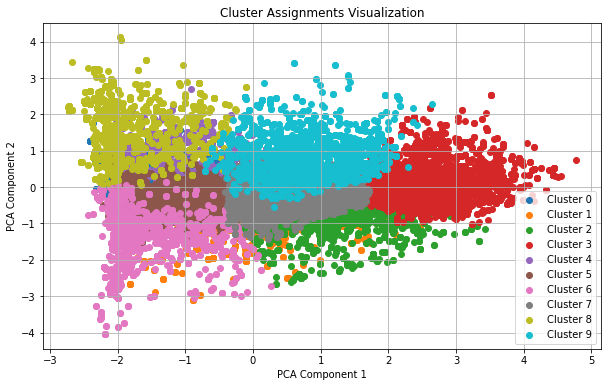

In [40]:
# Predict cluster assignments
assignments = kmeans.predict(data)

# Visualize the cluster assignments
kmeans.visualize_clusters(data, assignments)



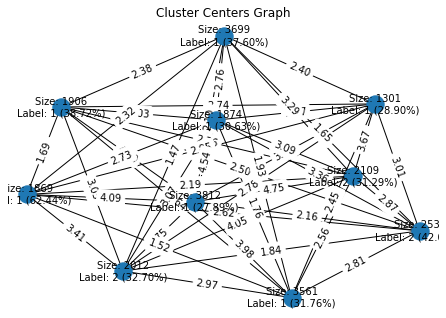

<Figure size 432x288 with 0 Axes>

In [41]:
# Visualize the cluster centers graph
labels = np.array(labels)
kmeans.visualize_cluster_graph(data, assignments, labels)

In [42]:
class KMeansPyTorch:
    def __init__(self, num_clusters, num_iterations=100, batch_size=1000, device='cuda'):
        self.num_clusters = num_clusters
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.cluster_centers = None
        self.device = device

    def fit(self, data):
        num_samples, num_features = data.shape
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)
        initial_indices = np.random.choice(num_samples, self.num_clusters, replace=False)
        self.cluster_centers = data_tensor[initial_indices].clone()

        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance

        for iteration in range(self.num_iterations):
            print(f"Iteration {iteration + 1}/{self.num_iterations}")
            all_assignments = []
            for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
                distances = compute_distance(batch[0], self.cluster_centers)
                assignments = torch.argmin(distances, dim=1)
                all_assignments.append(assignments)
            all_assignments = torch.cat(all_assignments)
            new_centers = []
            for cluster_idx in range(self.num_clusters):
                cluster_points = data_tensor[all_assignments == cluster_idx]
                if len(cluster_points) > 0:
                    new_center = cluster_points.mean(dim=0)
                else:
                    new_center = self.cluster_centers[cluster_idx]  # Keep the same if no points are assigned
                new_centers.append(new_center)
            self.cluster_centers = torch.stack(new_centers)

    def predict(self, data):
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)
        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance
        final_assignments = []
        for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
            distances = compute_distance(batch[0], self.cluster_centers)
            assignments = torch.argmin(distances, dim=1)
            final_assignments.append(assignments)
        final_assignments = torch.cat(final_assignments)
        return final_assignments.cpu().numpy()

    def get_cluster_centers(self):
        return self.cluster_centers.cpu()

    def compute_inertia(self, data):
        data_tensor = torch.tensor(data, dtype=torch.float32).to(self.device)
        def compute_distance(x, centers):
            return torch.cdist(x, centers, p=2)  # Euclidean distance
        inertia = 0.0
        for batch in DataLoader(TensorDataset(data_tensor), batch_size=self.batch_size, shuffle=False):
            distances = compute_distance(batch[0], self.cluster_centers)
            min_distances = torch.min(distances, dim=1).values
            inertia += torch.sum(min_distances**2).item()
        return inertia

    def visualize_clusters(self, data, assignments):
        pca = PCA(n_components=2)
        data_reduced = pca.fit_transform(data)
        plt.figure(figsize=(10, 6))
        for i in range(self.num_clusters):
            cluster_points = data_reduced[assignments == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
        plt.legend()
        plt.title('Cluster Assignments Visualization')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True)
        plt.show()

    def visualize_cluster_graph(self, data, assignments, labels, output_file="cluster_graph.html"):
        G = nx.Graph()
        cluster_centers = self.get_cluster_centers().numpy()
        assignments = np.array(assignments)
        labels = np.array(labels)
        cluster_sizes = [(assignments == i).sum().item() for i in range(self.num_clusters)]
        cluster_labels = []
        for i in range(self.num_clusters):
            cluster_label_counts = np.bincount(labels[assignments == i])
            most_common_label = cluster_label_counts.argmax()
            most_common_label_count = cluster_label_counts[most_common_label]
            percentage = (most_common_label_count / cluster_sizes[i]) * 100
            cluster_labels.append((most_common_label, percentage))
        for i, (center, (label, percentage)) in enumerate(zip(cluster_centers, cluster_labels)):
            G.add_node(i, size=cluster_sizes[i], title=f'Size: {cluster_sizes[i]}\nLabel: {label} ({percentage:.2f}%)')
        for i in range(self.num_clusters):
            for j in range(i + 1, self.num_clusters):
                distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
                G.add_edge(i, j, weight=float(distance))

        pos = nx.spring_layout(G)

        # Create edge trace
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')

        # Create node trace
        node_x = []
        node_y = []
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
            )
        )

        node_adjacencies = []
        node_text = []
        for node, adjacencies in enumerate(G.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            node_info = G.nodes[node]['title']
            node_text.append(node_info)

        node_trace.marker.color = node_adjacencies
        node_trace.text = node_text

        fig = go.Figure(data=[edge_trace, node_trace],
                     layout=go.Layout(
                        title='<br>Network graph visualization',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                        )

        fig.write_html(output_file)
        print(f"Graph saved to {output_file}")

def kmeans_inertia(num_clusters, data, num_iterations, batch_size, device):
    kmeans = KMeansPyTorch(num_clusters=num_clusters, num_iterations=num_iterations, batch_size=batch_size, device=device)
    kmeans.fit(data)
    inertia = kmeans.compute_inertia(data)
    return inertia

def plot_elbow_curve(data, max_clusters, num_iterations=100, batch_size=1000, num_processes=4, device='cuda'):
    with Pool(num_processes) as pool:
        print("grt")
        tasks = [(k, data, num_iterations, batch_size, device) for k in range(1, max_clusters + 1)]
        inertias = pool.starmap(kmeans_inertia, tasks)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


In [46]:
data = X.copy()
optimal_clusters = 50  # Reduced number of clusters
kmeans = KMeansPyTorch(num_clusters=optimal_clusters, num_iterations=100, batch_size=1000, device='cuda')
kmeans.fit(data)

assignments = kmeans.predict(data)

kmeans.visualize_cluster_graph(data, assignments, labels, output_file="cluster_graph.html")


Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [45]:
plot_elbow_curve(data,5)

grt


KeyboardInterrupt: 